# 2.1 Keras 학습 분석

이번 실습에서는 모델이 학습하는 동안 변화하는 학습양상을 확인하는 방법을 알아본다

(1) CallBack

(2) History 확인

(3) 틀린 샘플 확인

(4) Confusion Matrix

In [1]:
import tensorflow.keras.utils as utils
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(X_train, Y_train),(X_test, Y_test) = datasets.mnist.load_data()
X_train_flat = X_train.reshape(60000, 28*28).astype('float32')/255.0
X_test_flat = X_test.reshape(10000, 28*28).astype('float32')/255.0
Y_train_onehot = utils.to_categorical(Y_train)
Y_test_onehot = utils.to_categorical(Y_test)

n_in = 28*28
n_out = np.shape(Y_test_onehot)[1]

In [3]:
def DNN_seq(n_in, n_out):
    # Coding Time (5 min) layer : 784 → 128 → 32 → 10, acitvation : relu → relu → softmax
    model = Sequential()
    model.add(Dense(units = 128, input_shape = (n_in,), activation = 'relu'))    # Dense : FClayer
    model.add(Dense(units = 32, input_shape = (128,), activation = 'relu'))
    model.add(Dense(units = 10, input_shape = (32,), activation = 'softmax'))
    return model

model = DNN_seq(n_in, n_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-09-05 16:41:38.157441: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-05 16:41:38.642244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:b3:00.0, compute capability: 8.6


## (1) Keras Callback
model의 fit() 함수로 학습을 진행하는 동안, 매 epoch마다 지정한 함수를 호출할 수 있음

ModelCheckpoint : 학습 중 모델 저장

EarlyStopping : 학습양상을 보고 학습을 조기에 종료

TensorBoard : tensorboard로 확인할 수 있도록 학습양상을 기록

외에 kereas.callbacks.Callback을 상속받아 원하는 callback 함수를 만들 수 있음
    
https://keras.io/callbacks/

In [4]:
# 학습과정을 저장할 directory 생성
import os
import datetime

def make_dir(path):
    today = str(datetime.date.today())
    path_date = path+'/'+today
    
    if not os.path.exists(path_date):
        os.makedirs(path_date)
    return path_date

In [5]:
model_path=make_dir('./model')
tensorboard_path=make_dir('./tensorboard')

modelconfig = str(n_in)+'_'+str(n_out)
model_name_path = model_path+'/'+modelconfig+"_{epoch:02d}-{loss:.4f}_{val_loss:.4f}_{val_accuracy:.4f}.h5"

print(model_name_path)
print(tensorboard_path)

./model/2022-09-05/784_10_{epoch:02d}-{loss:.4f}_{val_loss:.4f}_{val_accuracy:.4f}.h5
./tensorboard/2022-09-05


필요한 callback 함수들을 정의하고 list로 fit() 함수에 전달

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

# Coding Time
# Callback list (checkpointer, earlystopper, tb_saver)

checkpointer = ModelCheckpoint(filepath = model_name_path,
                              monitor = 'val_accuracy',
                              verbose = 0,
                              save_best_only = True)

earlystopper = EarlyStopping(monitor = 'val_accuracy',
                            patience = 5,
                            verbose = 0,
                            mode = 'auto')

tb_saver = TensorBoard(log_dir = tensorboard_path,
                      write_graph = True)

callback_list = [checkpointer, tb_saver, earlystopper]



# Train (batch : 256, epochs : 50, validation_split : 0.3, verbose : 2, including callback list)
history = model.fit(X_train_flat, 
          Y_train_onehot,
          batch_size = 256, 
          epochs = 50, 
          validation_split = 0.3,
          verbose = 2,
          callbacks = callback_list)

2022-09-05 14:43:00.910240: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-05 14:43:00.910301: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-05 14:43:01.152497: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-05 14:43:01.152686: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-09-05 14:43:01.275644: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-05 14:43:01.275675: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 1/50


2022-09-05 14:43:01.545040: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-05 14:43:01.545405: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-09-05 14:43:01.573396: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 72 callback api events and 71 activity events. 
2022-09-05 14:43:01.575384: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-05 14:43:01.577527: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./tensorboard/2022-09-05/train/plugins/profile/2022_09_05_14_43_01

2022-09-05 14:43:01.579716: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./tensorboard/2022-09-05/train/plugins/profile/2022_09_05_14_43_01/piai-Precision-7920-Tower.trace.json.gz
2022-09-05 14:43:01.583271: I tensorflow/core/profiler/rpc/client/save_

165/165 - 1s - loss: 3.2450e-04 - accuracy: 1.0000 - val_loss: 0.1439 - val_accuracy: 0.9754
Epoch 2/50
165/165 - 1s - loss: 3.0234e-04 - accuracy: 1.0000 - val_loss: 0.1438 - val_accuracy: 0.9756
Epoch 3/50
165/165 - 1s - loss: 3.1216e-04 - accuracy: 1.0000 - val_loss: 0.1467 - val_accuracy: 0.9753
Epoch 4/50
165/165 - 1s - loss: 2.6712e-04 - accuracy: 1.0000 - val_loss: 0.1459 - val_accuracy: 0.9752
Epoch 5/50
165/165 - 1s - loss: 2.4281e-04 - accuracy: 1.0000 - val_loss: 0.1482 - val_accuracy: 0.9756
Epoch 6/50
165/165 - 1s - loss: 2.3918e-04 - accuracy: 1.0000 - val_loss: 0.1490 - val_accuracy: 0.9757
Epoch 7/50
165/165 - 1s - loss: 2.0683e-04 - accuracy: 1.0000 - val_loss: 0.1501 - val_accuracy: 0.9752
Epoch 8/50
165/165 - 1s - loss: 1.9229e-04 - accuracy: 1.0000 - val_loss: 0.1505 - val_accuracy: 0.9755
Epoch 9/50
165/165 - 1s - loss: 1.8181e-04 - accuracy: 1.0000 - val_loss: 0.1515 - val_accuracy: 0.9753
Epoch 10/50
165/165 - 1s - loss: 1.6453e-04 - accuracy: 1.0000 - val_loss: 

In [14]:
os.listdir(model_path)

['784_10_02-0.2055_0.1878_0.9462.h5',
 '784_10_27-0.0026_0.1266_0.9730.h5',
 '784_10_29-0.0018_0.1270_0.9743.h5',
 '784_10_18-0.0135_0.1075_0.9724.h5',
 '784_10_09-0.0516_0.1109_0.9684.h5',
 '784_10_01-0.0079_0.1443_0.9723.h5',
 '784_10_22-0.0070_0.1159_0.9728.h5',
 '784_10_08-0.0599_0.1116_0.9679.h5',
 '784_10_03-0.1533_0.1755_0.9487.h5',
 '784_10_05-0.0006_0.1374_0.9756.h5',
 '784_10_06-0.0825_0.1257_0.9640.h5',
 '784_10_13-0.0279_0.1093_0.9707.h5',
 '784_10_04-0.0008_0.1374_0.9751.h5',
 '784_10_04-0.1225_0.1368_0.9617.h5',
 '784_10_02-0.0003_0.1438_0.9756.h5',
 '784_10_10-0.0432_0.1062_0.9706.h5',
 '784_10_06-0.0002_0.1490_0.9757.h5',
 '784_10_03-0.0016_0.1385_0.9740.h5',
 '784_10_30-0.0016_0.1280_0.9748.h5',
 '784_10_05-0.0985_0.1289_0.9637.h5',
 '784_10_01-0.5715_0.2505_0.9271.h5',
 '784_10_07-0.0707_0.1168_0.9666.h5',
 '784_10_01-0.0003_0.1439_0.9754.h5',
 '784_10_25-0.0043_0.1215_0.9729.h5']

## (2)-1 history를 통한 결과 plotting
fit() 함수는 history 객체를 반환함

history['loss']: epoch 마다 기록되는 train loss

history['accuracy'] : accuracy를 측정할 수 있는 문제이며 compile() 때 metric으로 accuracy를 지정하였다면 기록됨
    
history['val_loss'] : 검증 데이터가 있다면 기록되는 validation loss

history['val_accuracy'] : 검증 데이터가 있고 accuracy를 측정할 수 있다면 기록되는 validation accuracy 

In [15]:
print(history.history['loss'])
print(history.history['val_accuracy'])

[0.0003245044208597392, 0.0003023438330274075, 0.00031216134084388614, 0.0002671168767847121, 0.00024280889192596078, 0.0002391840098425746, 0.0002068337198579684, 0.00019228889141231775, 0.00018181164341513067, 0.00016453083662781864, 0.00015212931612040848]
[0.9754444360733032, 0.9755555391311646, 0.9753333330154419, 0.9752222299575806, 0.9755555391311646, 0.9757221937179565, 0.9752222299575806, 0.9754999876022339, 0.9753333330154419, 0.9757221937179565, 0.9753888845443726]


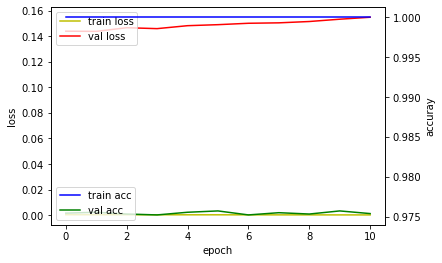

In [16]:
# matplotlib를 이용하여 history 객체 내부에 저장된 값들을 graph로 표현
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 저장하고 싶을 경우
#fig.savefig('final.png')

## (2)-2 텐서보드를 통한 결과 확인

tensorflow의 가시화 툴인 tensorboard로 학습과정을 확인
터미널에 tensorboard --logdir=./tensorboard/{날짜} 를 타이핑 후, localhost:6006으로 들어감

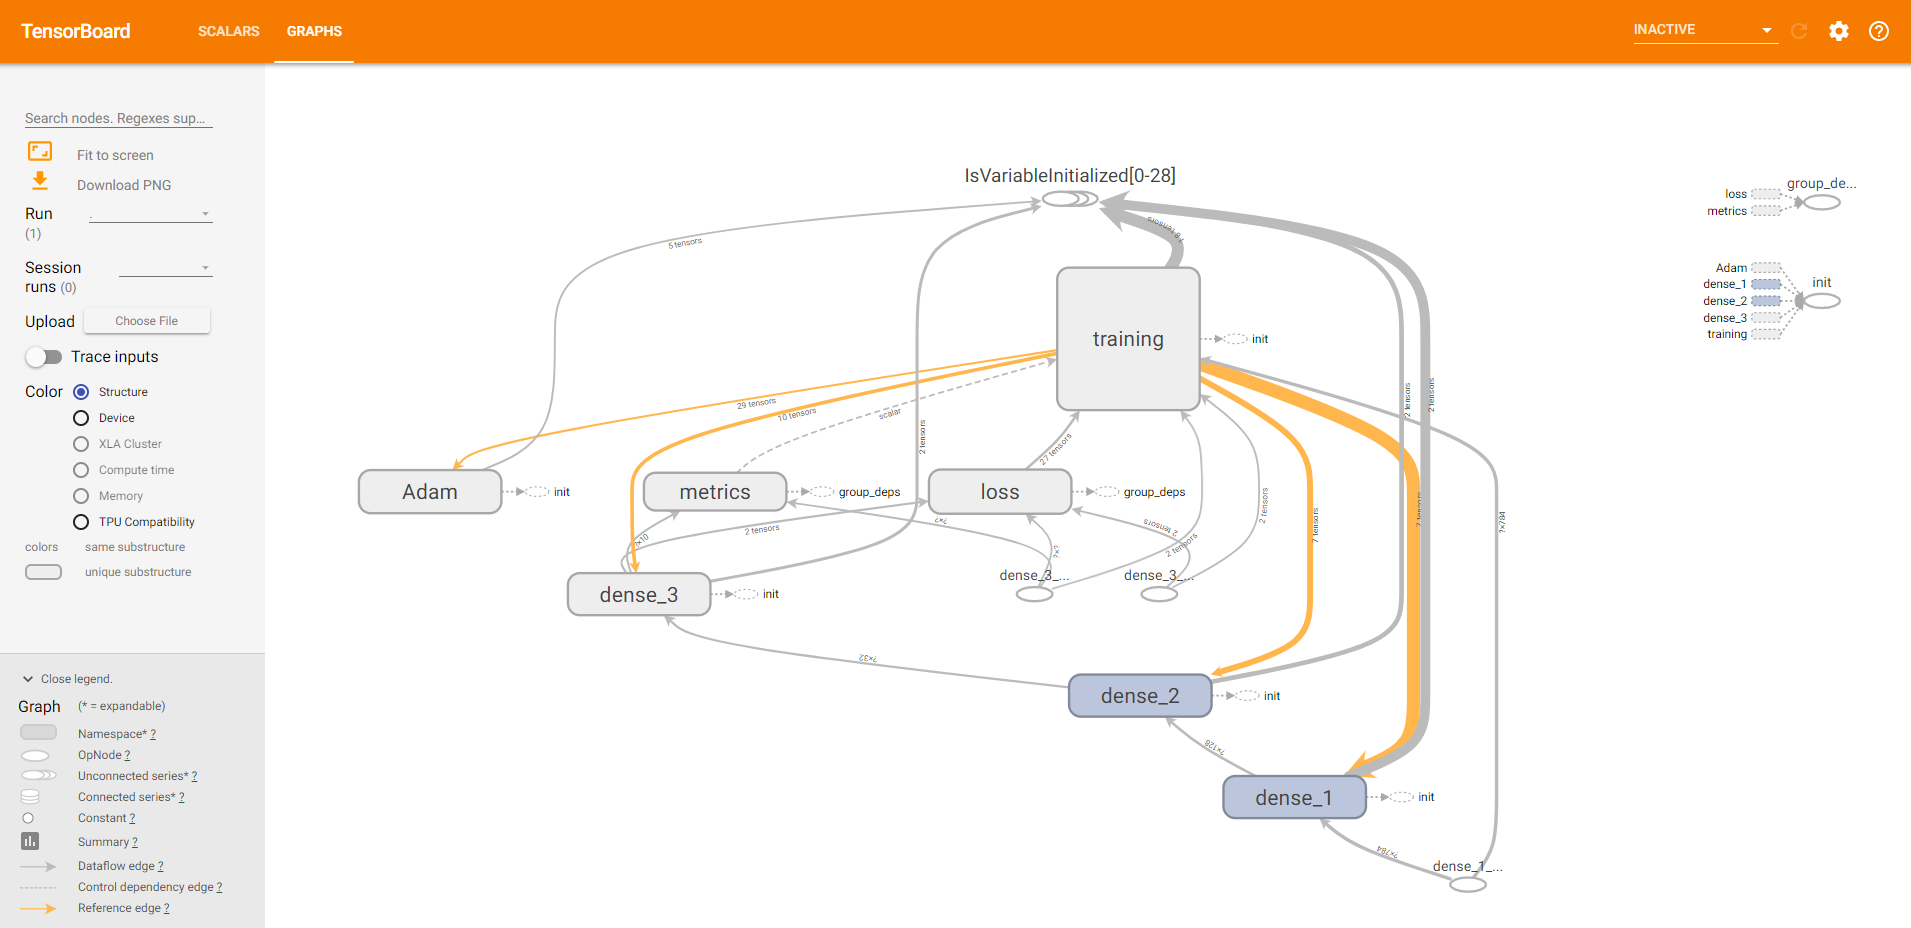

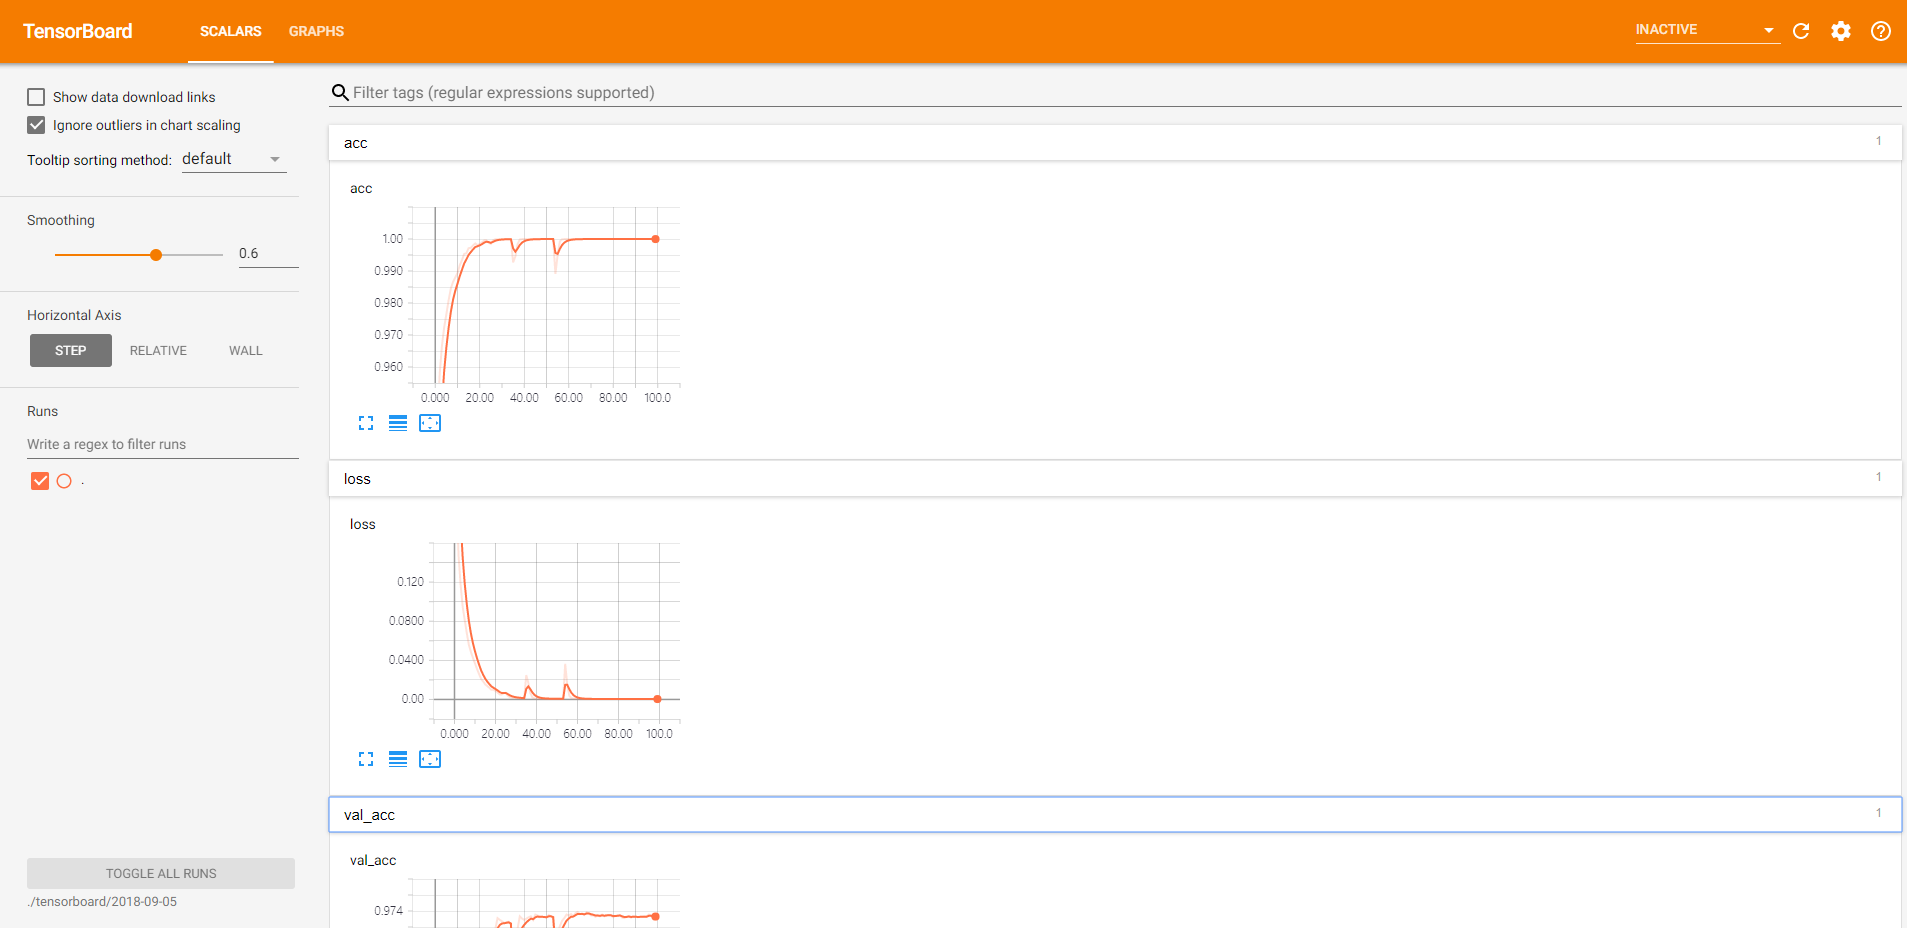

## (3) 틀린샘플 찾기

real_label : 8, predict_label : 2


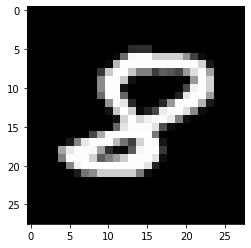

real_label : 4, predict_label : 6


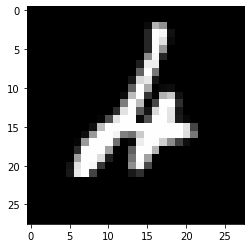

real_label : 2, predict_label : 7


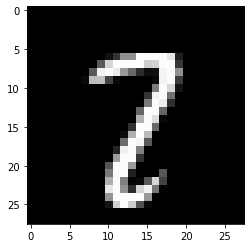

real_label : 5, predict_label : 3


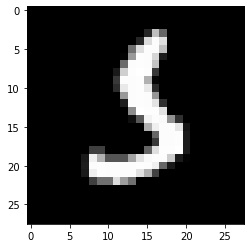

real_label : 6, predict_label : 0


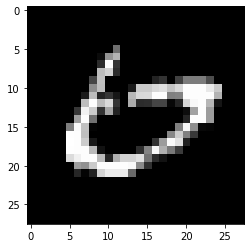

In [17]:
def check_error(Number_Of_Error):
    
    # Coding Time
    cnt = 0
    for i in range(len(Y_test)):
        # 모델 예측 값 도출
        test_data = X_test[i].reshape(1, 28 * 28)
        pred_y = model.predict(test_data, verbose = 0)
        pred_y = pred_y.argmax()

        
        # 예측값과 라벨이 다를 경우, print와 샘플 확인
        if pred_y != Y_test[i]:
            print('real_label : {}, predict_label : {}'.format(Y_test[i], pred_y))
            plt.imshow(X_test[i], cmap = 'gray')
            plt.show()
            cnt += 1

            
        # cnt 값이 틀린 샘플갯수만큼 찾을 시 break
        if cnt >= Number_Of_Error:
            break
            
check_error(5)

## (4) Confusion Matrix 만들기 with pandas

In [19]:
import pandas as pd

# Coding Time
#X_test_flat, batch_size 활용하여 predict된 결과 list 만들기
pred_y = model.predict(X_test_flat, batch_size = 10000, verbose = 0)
Y_pred = [x.argmax() for x in pred_y]


# Pandas를 활용하여 confusion matrix 만들기 
data = {'Real' : Y_test, 'Predict' : Y_pred}
df = pd.DataFrame(data, columns = ['Real', 'Predict'])
conf_mat = pd.crosstab(df['Real'], df['Predict'], rownames = ['Real'], colnames = ['Predict'])

print(conf_mat)

Predict    0     1     2    3    4    5    6     7    8    9
Real                                                        
0        969     0     1    2    2    1    2     1    1    1
1          0  1125     3    1    0    0    2     1    3    0
2          6     4  1011    1    1    0    2     4    3    0
3          0     1     3  990    0    3    0     4    4    5
4          1     0     1    0  964    0    5     2    1    8
5          2     0     0   10    3  868    2     0    6    1
6          4     4     1    2    3    3  939     0    2    0
7          1     4     6    2    1    1    0  1006    2    5
8          6     1     4    6    4    2    5     7  936    3
9          2     3     0    5    8    3    0     7    3  978


## 2.2 Simple CNN
이번 실습은 classifier 역할을 하는 DNN 앞에, feature extractor 역할을 하는 Covolution layer를 및 Maxplling layer를 덧붙여

CNN 모델을 만들고 학습시켜 볼 것이다.

## (1) 데이터셋

In [20]:
(X_train, Y_train),(X_test, Y_test) = datasets.mnist.load_data()
print(X_train.shape, Y_train.shape)

(60000, 28, 28) (60000,)


MNIST 데이터는 load했을 때 channel이 없기 때문에 channel을 추가하여 3차원 이미지로 바꿔주어야 함(batch차원 제외)

Tensorflow base에서는 (batch, image row, image column, image channel)으로 이미지를 학습

Teano base에서는 (batch, image channel, image row, image column)으로 이미지를 학습

backend.image_data_format()로 channel의 위치를 확인하고 reshape


In [21]:
from tensorflow.keras import backend
backend.image_data_format()

'channels_last'

In [22]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

Y_train = utils.to_categorical(Y_train)
Y_test = utils.to_categorical(Y_test)

print(X_train.shape, Y_train.shape)

n_in = X_train.shape[1:]
n_out = Y_train.shape[-1]

(60000, 28, 28, 1) (60000, 10)


## (2) 모델링

<사용되는 Layer>

`Conv2D` : 이미지에 필터의 파라미터를 convolution 연산하여 다음 layer로 전달

https://keras.io/layers/convolutional/#conv2d

`MaxPooling2D` : 필터에 겹치는 값들 중 가장 큰 값만 다음 layer로 전달

https://keras.io/layers/pooling/#maxpooling2d

`Flatten` : 다차원 tensor를 1차원 벡터로 변환

https://keras.io/layers/core/#flatten

In [23]:
from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, ReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
________________________________________________

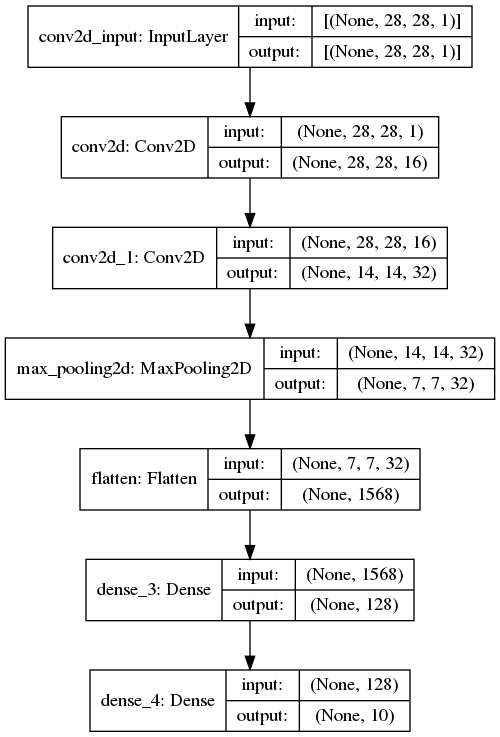

In [26]:
def CNN(n_in, n_out):
    # Coding Time 
    # Feature Extraction
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = n_in))
    model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', strides = (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    
    # Classifier
    model.add(Flatten())
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dense(n_out, activation = 'softmax'))
    return model

model=CNN(n_in, n_out)
model.summary()

from tensorflow.keras.utils import plot_model
%matplotlib inline
plot_model(model, show_shapes=True)

## (3) 모델의 학습과정 설정

optimizer에 문자열 대신에 파라미터를 수정한 optimizer를 입력할 수 있음

https://keras.io/optimizers/#adam

In [27]:
# Coding Time
# adam : learning rate= 0.001 / beta_1 = 0.9 / beta_2=0.999 / decay=1e-6
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 1e-6, epsilon = None, amsgrad = False)

# compile (loss : categorical / optimizer : adam / metric : accuracy)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

## (4) 모델 학습시키기

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

# Coding Time (batch : 128 / epoch : 20 / validation : 0.2 / callback : earlystopper with 5 patience)
earlystopper = EarlyStopping(monitor = 'val_accuracy', patience = 5, verbose = 0, mode = 'auto')
history = model.fit(X_train, Y_train,
                   batch_size = 128,
                   epochs = 20,
                   validation_split = 0.2,
                   callbacks = [earlystopper]);

Epoch 1/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.0991 - val_accuracy: 0.9852
Epoch 2/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0089 - accuracy: 0.9974 - val_loss: 0.1076 - val_accuracy: 0.9848
Epoch 3/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0076 - accuracy: 0.9978 - val_loss: 0.1161 - val_accuracy: 0.9812
Epoch 4/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0126 - accuracy: 0.9965 - val_loss: 0.1025 - val_accuracy: 0.9834
Epoch 5/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.1065 - val_accuracy: 0.9841
Epoch 6/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0086 - accuracy: 0.9977 - val_loss: 0.1071 - val_accuracy: 0.9843


## (5) 모델 평가하기

In [30]:
# Coding Time
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 0s 3ms/step - loss: 0.0951 - accuracy: 0.9839
loss : 0.0951, accruracy : 0.9839


## 2.3 BatchNormalization

## (2) 모델링

<사용되는 Layer>

`BatchNormalization` : activation에 입력되기 전 데이터를 가우시안 분포로 정규화하여 학습 안정화

https://keras.io/layers/normalization/#batchnormalization

`Dropout` : 일부 뉴런을 drop하여 overfitting을 방지

https://keras.io/layers/core/#dropout

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 32)         

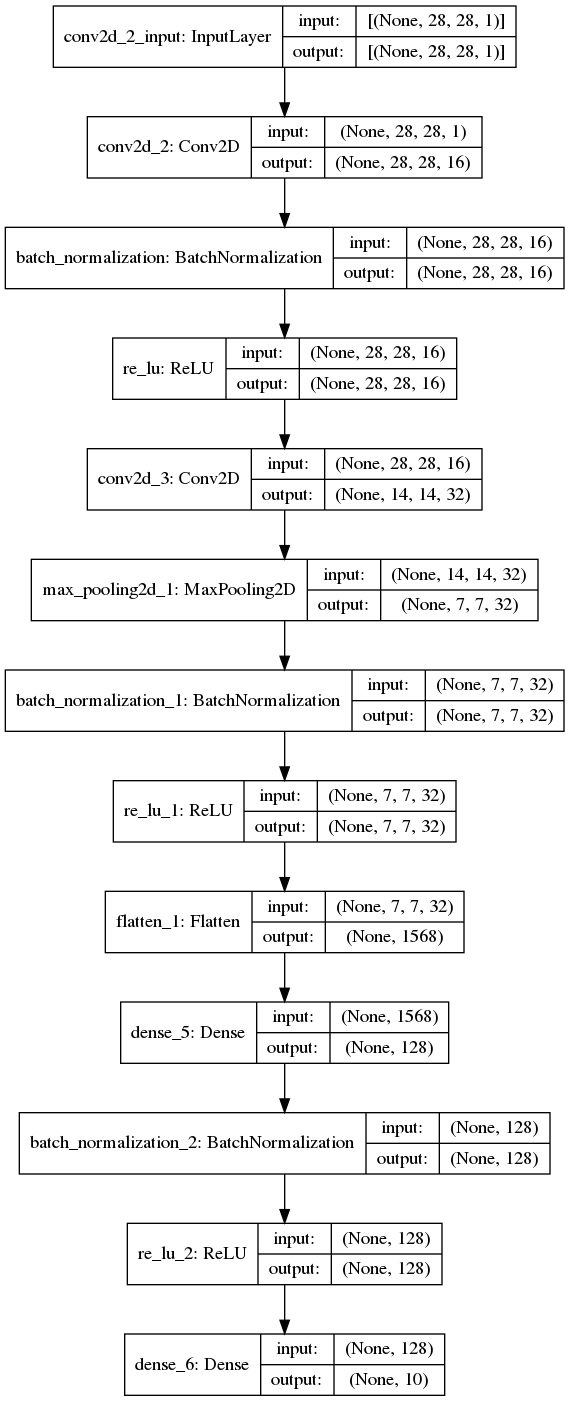

In [31]:
def CNN_BN(n_in, n_out):
    # Coding Time
    # Feature Extraction
    model = Sequential()
    model.add(Conv2D(16, kernel_size= (3, 3), padding = 'same', input_shape = n_in))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(32, (3,3), padding = 'same', strides = (2, 2)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(ReLU())

    
    # Classfier
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(n_out, activation = 'softmax'))
    return model

model=CNN_BN(n_in, n_out)
model.summary()

from tensorflow.keras.utils import plot_model
%matplotlib inline
plot_model(model, show_shapes=True)

## (3) 모델의 학습과정 설정

In [32]:
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=1e-6, epsilon=None, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

## (4) 모델 학습시키기

In [33]:
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=0, mode='auto')
history = model.fit(X_train, Y_train, batch_size=128, epochs=30, validation_split=0.2, callbacks = [earlystopper])

Epoch 1/30
375/375 [==============================] - 3s 6ms/step - loss: 0.1489 - accuracy: 0.9589 - val_loss: 0.0705 - val_accuracy: 0.9790
Epoch 2/30
375/375 [==============================] - 2s 6ms/step - loss: 0.0423 - accuracy: 0.9883 - val_loss: 0.0534 - val_accuracy: 0.9839
Epoch 3/30
375/375 [==============================] - 2s 6ms/step - loss: 0.0251 - accuracy: 0.9940 - val_loss: 0.0450 - val_accuracy: 0.9870
Epoch 4/30
375/375 [==============================] - 2s 6ms/step - loss: 0.0172 - accuracy: 0.9954 - val_loss: 0.0446 - val_accuracy: 0.9861
Epoch 5/30
375/375 [==============================] - 2s 6ms/step - loss: 0.0113 - accuracy: 0.9973 - val_loss: 0.0477 - val_accuracy: 0.9852
Epoch 6/30
375/375 [==============================] - 2s 7ms/step - loss: 0.0082 - accuracy: 0.9982 - val_loss: 0.0409 - val_accuracy: 0.9880
Epoch 7/30
375/375 [==============================] - 2s 6ms/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 0.0463 - val_accuracy: 0.9862
Epoch 

## (5) 모델 평가하기

In [34]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 0s 3ms/step - loss: 0.0348 - accuracy: 0.9912
loss : 0.0348, accruracy : 0.9912


## 2.4 DropOut

## (2) 모델링

<사용되는 Layer>

`Dropout` : 일부 뉴런을 drop하여 overfitting을 방지

https://keras.io/layers/core/#dropout
    
보통 batchnormalization, dropout은 동시에 사용하지 않음

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
re_lu_3 (ReLU)               (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 7, 7, 32)         

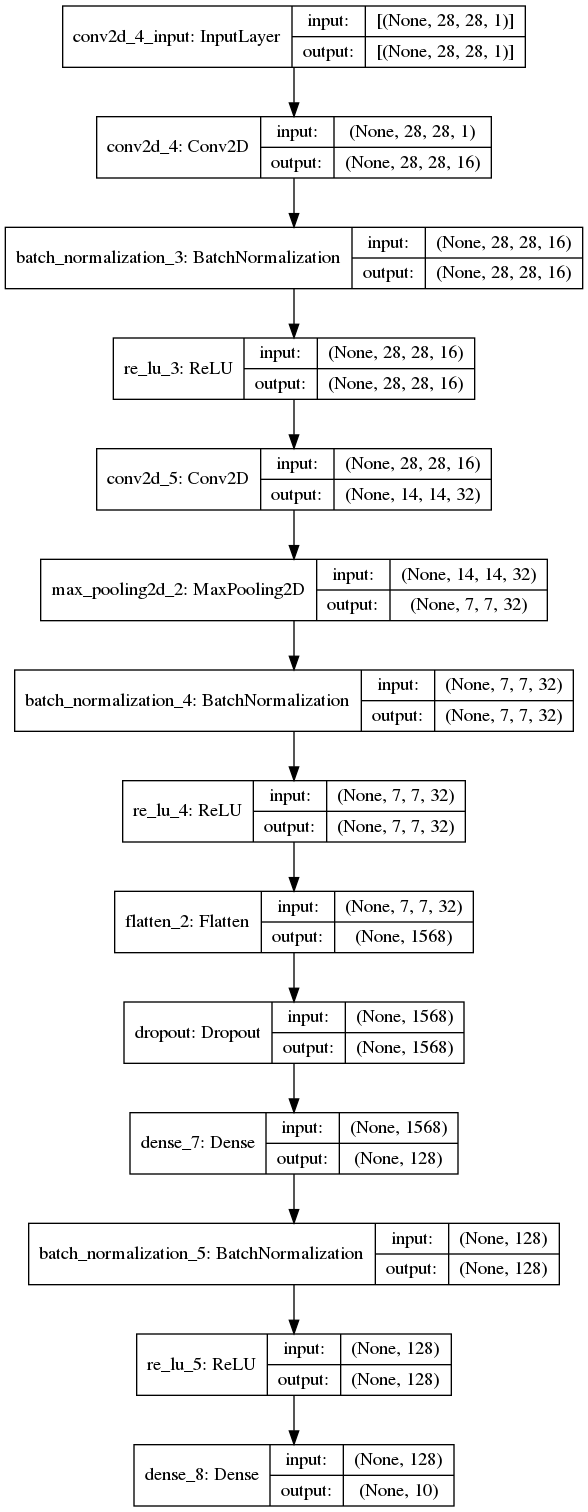

In [35]:
def CNN_Dropout(n_in, n_out):
    # Feature Extraction
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', input_shape=n_in))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(32, (3, 3), padding='same',strides=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(ReLU())

    
    # Classifier
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(n_out, activation='softmax'))
    return model

model=CNN_Dropout(n_in, n_out)
model.summary()

from tensorflow.keras.utils import plot_model
%matplotlib inline
plot_model(model, show_shapes=True)

## (3) 모델의 학습과정 설정

In [36]:
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=1e-6, epsilon=None, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

## (4) 모델 학습시키기

In [37]:
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=0, mode='auto')
history = model.fit(X_train, Y_train, batch_size=128, epochs=30, validation_split=0.2, callbacks = [earlystopper])

Epoch 1/30
375/375 [==============================] - 3s 7ms/step - loss: 0.2863 - accuracy: 0.9160 - val_loss: 0.0705 - val_accuracy: 0.9803
Epoch 2/30
375/375 [==============================] - 2s 6ms/step - loss: 0.1023 - accuracy: 0.9682 - val_loss: 0.0523 - val_accuracy: 0.9837
Epoch 3/30
375/375 [==============================] - 2s 6ms/step - loss: 0.0793 - accuracy: 0.9748 - val_loss: 0.0486 - val_accuracy: 0.9853
Epoch 4/30
375/375 [==============================] - 2s 6ms/step - loss: 0.0661 - accuracy: 0.9791 - val_loss: 0.0436 - val_accuracy: 0.9863
Epoch 5/30
375/375 [==============================] - 2s 6ms/step - loss: 0.0589 - accuracy: 0.9810 - val_loss: 0.0335 - val_accuracy: 0.9893
Epoch 6/30
375/375 [==============================] - 2s 6ms/step - loss: 0.0522 - accuracy: 0.9831 - val_loss: 0.0368 - val_accuracy: 0.9888
Epoch 7/30
375/375 [==============================] - 2s 6ms/step - loss: 0.0459 - accuracy: 0.9847 - val_loss: 0.0349 - val_accuracy: 0.9899
Epoch 

## (5) 모델 평가하기

In [38]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 0s 3ms/step - loss: 0.0241 - accuracy: 0.9923
loss : 0.0241, accruracy : 0.9923


# 2.5 Keras MNIST - 모델의 성능을 직접 더 높혀보자
 - CNN의 구조를 바꾸어 나만의 모델을 만들어보자
 - 목표 정확도: 99.5% 만들기
 - 바꿀 수 있는 하이퍼 파라미터: Learning Rate, Batch size, Epochs, Optimizer, Activation Function, 모델 레이어 구조, BN, DO 등

## (2) Keras 모델링

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_13 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
re_lu_13 (ReLU)              (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 7, 7, 32)          128       
_________________________________________________________________
re_lu_14 (ReLU)              (None, 7, 7, 32)         

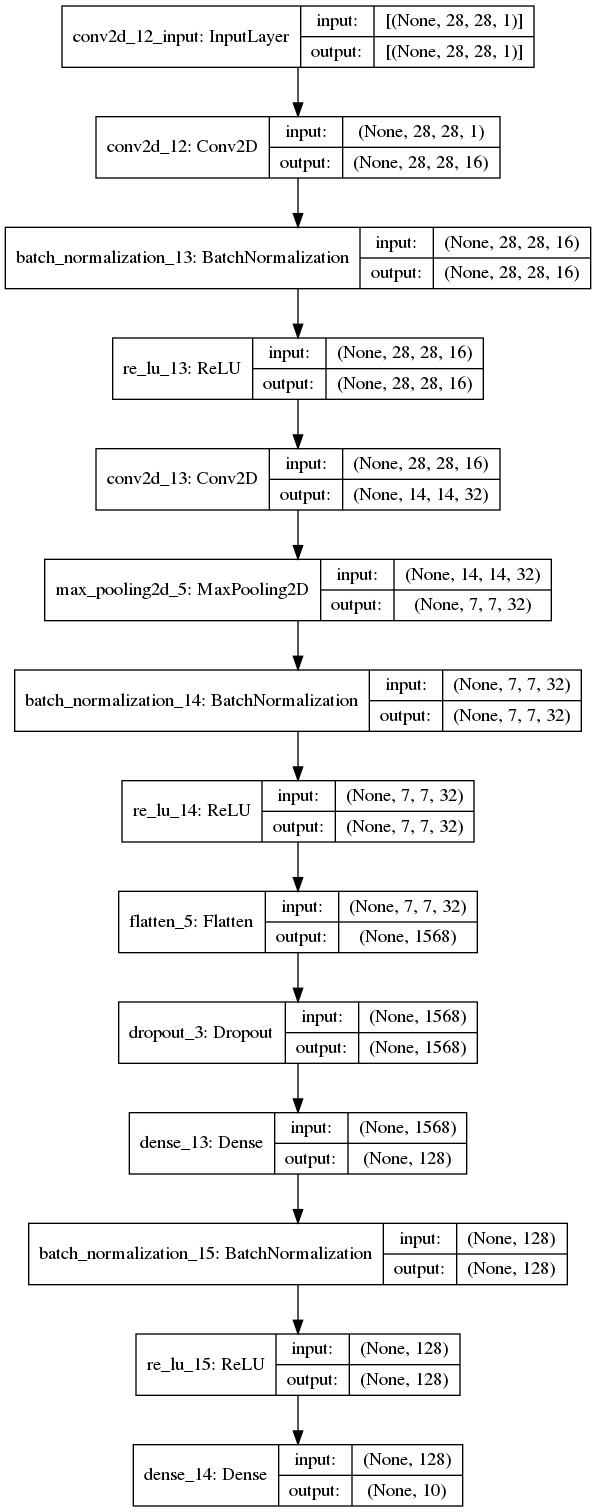

In [51]:
def CNN_mymodel(n_in, n_out) :
    # Feature Extraction
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3, 3), padding = 'same', input_shape = n_in))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(32, (3, 3), padding = 'same', strides = (2, 2)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    # Classifier
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(n_out, activation = 'softmax'))
    return model

model = CNN_mymodel(n_in, n_out)
model.summary()

from tensorflow.keras.utils import plot_model
%matplotlib inline
plot_model(model, show_shapes = True)

## (3) 모델의 학습과정 설정

In [52]:
adam = Adam(learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.999,
            decay = 1e-6, epsilon = None, amsgrad = False)

model.compile(loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['accuracy'])

## (4) 모델 학습시키기

In [70]:
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=0, mode='auto')

history = model.fit(X_train, 
                    Y_train, 
                    batch_size=256, 
                    epochs=50, 
                    validation_split=0.4, 
                    callbacks = [earlystopper])

Epoch 1/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0067 - accuracy: 0.9977 - val_loss: 0.0198 - val_accuracy: 0.9963
Epoch 2/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.0193 - val_accuracy: 0.9963
Epoch 3/50
141/141 [==============================] - 1s 10ms/step - loss: 0.0056 - accuracy: 0.9981 - val_loss: 0.0180 - val_accuracy: 0.9968
Epoch 4/50
141/141 [==============================] - 1s 10ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0218 - val_accuracy: 0.9961
Epoch 5/50
141/141 [==============================] - 1s 10ms/step - loss: 0.0063 - accuracy: 0.9979 - val_loss: 0.0197 - val_accuracy: 0.9960
Epoch 6/50
141/141 [==============================] - 1s 10ms/step - loss: 0.0065 - accuracy: 0.9976 - val_loss: 0.0231 - val_accuracy: 0.9953
Epoch 7/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0083 - accuracy: 0.9976 - val_loss: 0.0186 - val_accuracy: 0.9960
Ep

## (5) 모델 평가하기

In [71]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size = 128)
print('loss : %.4f, accuracy : %.4f' % (loss_and_accuracy[0], loss_and_accuracy[1]))

79/79 [==============================] - 0s 3ms/step - loss: 0.0361 - accuracy: 0.9933
loss : 0.0361, accuracy : 0.9933
